# ** Screening Test: **

As part of the screening test, you will write code to parse the JSON file provided(algoparams_from_ui) and kick off in sequence the following machine learning steps programmatically.

Keep in mind your final code should be able to parse any Json that follows this format.

It is crucial you have a generic parse that can read the various steps like feature handling, feature generation and model building using Grid search after parsing hyper params.


1) Read the target and type of regression to be run

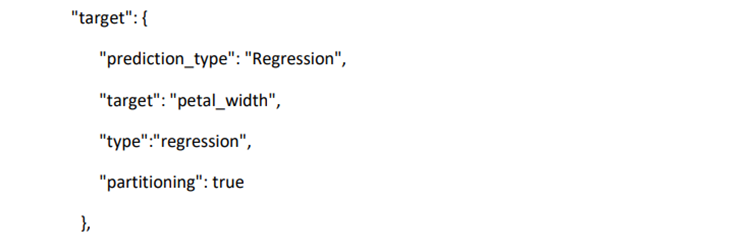

2) Read the features (which are column names in the csv) and figure out what missing imputation needs to be applied and apply that to the columns loaded in a dataframe

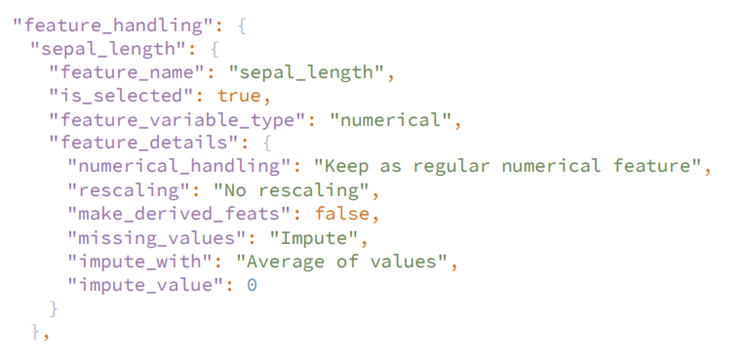
 
3) Compute feature reduction based on input. See the screenshot below where there can be No Reduction, Corr with Target, Tree-based, PCA.

Please make sure you write code so that all options can work.

If we rerun your code with a different Json it should work if we switch No Reduction to say PCA.

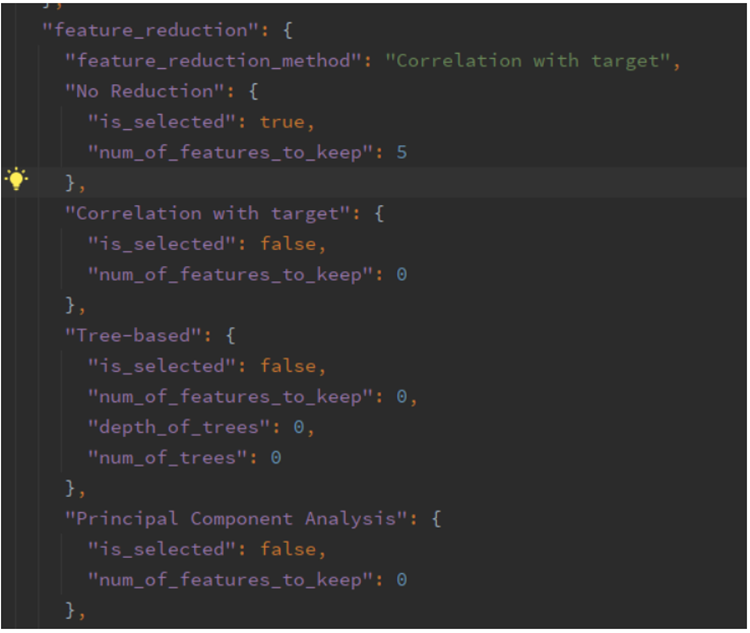
 
4) Parse the Json and make the model objects (using sklean) that can handle what is required in the “prediction_type” specified in the JSON (See #1 where “prediction_type” is specified).

Keep in mind not to pick models that don’t apply for the prediction_type specified
 
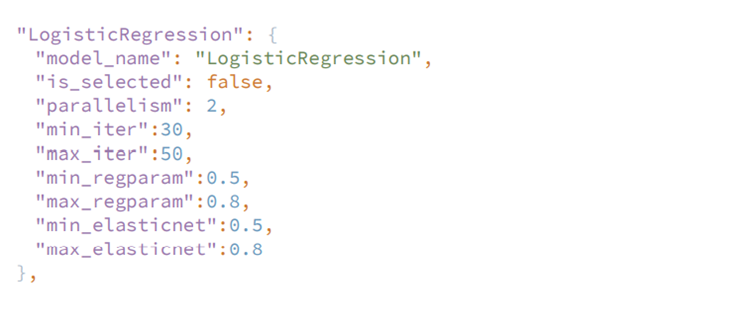

5) Run the fit and predict on each model – keep in mind that you need to do hyper parameter tuning i.e., use GridSearchCV

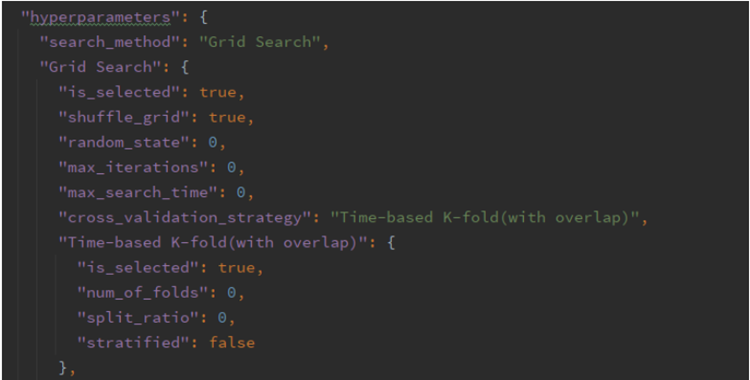

6) Log to the console the standard model metrics that apply




In [4]:
!pip install striprtf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing all required libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error,accuracy_score, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.svm import SVC
import time
import json
from striprtf.striprtf import rtf_to_text
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,Lasso,LogisticRegression,SGDRegressor,Ridge,ElasticNet, SGDClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier,GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest,f_regression, SelectFromModel
import warnings
warnings.filterwarnings("ignore")

### Converting rtf into text for accessing the json script easily

In [6]:
path_fil = "/content/drive/MyDrive/Internship /Screening Test - DS/Data/algoparams_from_ui.json.rtf"
with open(path_fil, 'r') as file:
  rtf = file.read()
  text = rtf_to_text(rtf)
print(text)

{
    "session_name": "test",
    "session_description": "test",
    "design_state_data": {

      "session_info" : {
        "project_id": "1",
        "experiment_id": "kkkk-11",
        "dataset":"iris_modified.csv",
        "session_name": "test",
        "session_description": "test"
        },

      "target": {
        "prediction_type": "Regression",
        "target": "petal_width",
        "type":"regression",
        "partitioning": true
      },
      "train": {
        "policy": "Split the dataset",
        "time_variable": "sepal_length",
        "sampling_method": "No sampling(whole data)",
        "split": "Randomly",
        "k_fold": false,
        "train_ratio": 0,
        "random_seed": 0
      },
      "metrics": {
        "optomize_model_hyperparameters_for": "AUC",
        "optimize_threshold_for": "F1 Score",
        "compute_lift_at": 0,
        "cost_matrix_gain_for_true_prediction_true_result": 1,
        "cost_matrix_gain_for_true_prediction_false_result": 0,

### Create a json file

In [7]:
out_file = open("/content/algoparams_from_ui.json", "w") 
json.dump(text, out_file, indent = 33)

json_file = open('/content/algoparams_from_ui.json','r')

data = json.load(json_file)

data = json.loads(data)

In [8]:
type(data)

dict

In [9]:
data = pd.DataFrame(data)
data

,session_name,session_description,design_state_data
algorithms,test,test,{'RandomForestClassifier': {'model_name': 'Ran...
feature_generation,test,test,"{'linear_interactions': [['petal_length', 'sep..."
feature_handling,test,test,{'sepal_length': {'feature_name': 'sepal_lengt...
feature_reduction,test,test,"{'feature_reduction_method': 'Tree-based', 'nu..."
hyperparameters,test,test,"{'stratergy': 'Grid Search', 'shuffle_grid': T..."
metrics,test,test,"{'optomize_model_hyperparameters_for': 'AUC', ..."
probability_calibration,test,test,{'probability_calibration_method': 'Sigmoid - ...
session_info,test,test,"{'project_id': '1', 'experiment_id': 'kkkk-11'..."
target,test,test,"{'prediction_type': 'Regression', 'target': 'p..."
train,test,test,"{'policy': 'Split the dataset', 'time_variable..."


In [10]:
# data_file = pd.read_json('/content/algoparams_from_ui.json')
# data_file

### Reading the iris.csv file

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Internship /Screening Test - DS/Data/iris.csv')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [12]:
df = pd.get_dummies(df)
df

,sepal_length,sepal_width,petal_length,petal_width,species_Iris-setosa,species_Iris-versicolor,species_Iris-virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,0,1
146,6.3,2.5,5.0,1.9,0,0,1
147,6.5,3.0,5.2,2.0,0,0,1
148,6.2,3.4,5.4,2.3,0,0,1


### 1) Read the target and type of regression to be run

In [13]:
target = data.loc['target','design_state_data']['target']
target

'petal_width'

In [14]:
reg_type = data.loc['target','design_state_data']['type']
reg_type

'regression'

In [21]:
met = data.loc['metrics','design_state_data']
met

{'optomize_model_hyperparameters_for': 'AUC',
 'optimize_threshold_for': 'F1 Score',
 'compute_lift_at': 0,
 'cost_matrix_gain_for_true_prediction_true_result': 1,
 'cost_matrix_gain_for_true_prediction_false_result': 0,
 'cost_matrix_gain_for_false_prediction_true_result': 0,
 'cost_matrix_gain_for_false_prediction_false_result': 0}

### 2) Read the features (which are column names in the csv) and figure out what missing imputation needs to be applied and apply that to the columns loaded in a dataframe

In [15]:
handle_feat = data.loc['feature_handling','design_state_data']
handle_feat

{'sepal_length': {'feature_name': 'sepal_length',
  'is_selected': True,
  'feature_variable_type': 'numerical',
  'feature_details': {'numerical_handling': 'Keep as regular numerical feature',
   'rescaling': 'No rescaling',
   'make_derived_feats': False,
   'missing_values': 'Impute',
   'impute_with': 'Average of values',
   'impute_value': 0}},
 'sepal_width': {'feature_name': 'sepal_width',
  'is_selected': True,
  'feature_variable_type': 'numerical',
  'feature_details': {'numerical_handling': 'Keep as regular numerical feature',
   'rescaling': 'No rescaling',
   'make_derived_feats': False,
   'missing_values': 'Impute',
   'impute_with': 'custom',
   'impute_value': -1}},
 'petal_length': {'feature_name': 'petal_length',
  'is_selected': True,
  'feature_variable_type': 'numerical',
  'feature_details': {'numerical_handling': 'Keep as regular numerical feature',
   'rescaling': 'No rescaling',
   'make_derived_feats': False,
   'missing_values': 'Impute',
   'impute_with': '

In [22]:
def feature_handling(feature_handling, column_names, df):
    for col in column_names:
        try:
            if feature_handling[col]['feature_details']['impute_with'] == 'custom':
                df[col] = df[col].fillna(feature_handling[col]['feature_details']['impute_value'])
            elif feature_handling[col]['feature_details']['impute_with'] == 'Average of values': 
                df[col] = df[col].fillna(df[col].mean())
            elif feature_handling[col]['feature_details']['impute_with'] == 'Median values': 
                df[col] = df[col].fillna(df[col].median())
        except KeyError:
            print(col,"feature does not have 'impute_with' provided\n")
    print(df)

In [23]:
feature_handling(handle_feat, df.columns, df)

species_Iris-setosa feature does not have 'impute_with' provided

species_Iris-versicolor feature does not have 'impute_with' provided

species_Iris-virginica feature does not have 'impute_with' provided

     sepal_length  sepal_width  petal_length  petal_width  \
0             5.1          3.5           1.4          0.2   
1             4.9          3.0           1.4          0.2   
2             4.7          3.2           1.3          0.2   
3             4.6          3.1           1.5          0.2   
4             5.0          3.6           1.4          0.2   
..            ...          ...           ...          ...   
145           6.7          3.0           5.2          2.3   
146           6.3          2.5           5.0          1.9   
147           6.5          3.0           5.2          2.0   
148           6.2          3.4           5.4          2.3   
149           5.9          3.0           5.1          1.8   

     species_Iris-setosa  species_Iris-versicolor  species_Iri

In [24]:
data.loc['algorithms']['design_state_data']

{'RandomForestClassifier': {'model_name': 'Random Forest Classifier',
  'is_selected': False,
  'min_trees': 10,
  'max_trees': 30,
  'feature_sampling_statergy': 'Default',
  'min_depth': 20,
  'max_depth': 30,
  'min_samples_per_leaf_min_value': 5,
  'min_samples_per_leaf_max_value': 50,
  'parallelism': 0},
 'RandomForestRegressor': {'model_name': 'Random Forest Regressor',
  'is_selected': True,
  'min_trees': 10,
  'max_trees': 20,
  'feature_sampling_statergy': 'Default',
  'min_depth': 20,
  'max_depth': 25,
  'min_samples_per_leaf_min_value': 5,
  'min_samples_per_leaf_max_value': 10,
  'parallelism': 0},
 'GBTClassifier': {'model_name': 'Gradient Boosted Trees',
  'is_selected': False,
  'num_of_BoostingStages': [67, 89],
  'feature_sampling_statergy': 'Fixed number',
  'learningRate': [],
  'use_deviance': True,
  'use_exponential': False,
  'fixed_number': 22,
  'min_subsample': 1,
  'max_subsample': 2,
  'min_stepsize': 0.1,
  'max_stepsize': 0.5,
  'min_iter': 20,
  'max_i

### Prediction models are above mentioned.

### Random Forest Regressor

In [25]:
RandomForestRegressor_params = {'model_name': 'Random Forest Regressor',
                        'is_selected': True,'min_trees': 10,'max_trees': 20,
                        'feature_sampling_statergy': 'Default','min_depth': 20,
                        'max_depth': 25,'min_samples_per_leaf_min_value': 5,
                        'min_samples_per_leaf_max_value': 10,'parallelism': 0}
rf_metrics = [{'n_estimators':[10,15,20]},{'max_depth':[20,23,25]},{'min_samples_leaf':[5,7,10]}]

gs = GridSearchCV(estimator=RandomForestRegressor(),param_grid=rf_metrics)
gs.fit(df.drop(target, axis=1), df[target])
rf_reg = gs.best_estimator_
rf_reg.predict(df.drop(target, axis=1))

array([0.24529524, 0.18348662, 0.20287098, 0.17575227, 0.23916224,
       0.34322042, 0.2340085 , 0.24524418, 0.20808273, 0.16357553,
       0.27562418, 0.27810829, 0.18746315, 0.19601209, 0.2708399 ,
       0.28109733, 0.27102672, 0.24529524, 0.34303361, 0.27158867,
       0.32640967, 0.2659287 , 0.23501866, 0.31224322, 0.29522214,
       0.24627427, 0.30720152, 0.24808863, 0.23596173, 0.22865904,
       0.21378718, 0.2628561 , 0.25998999, 0.26853441, 0.16357553,
       0.20154481, 0.25648345, 0.16357553, 0.19601209, 0.2497649 ,
       0.24503205, 0.21662075, 0.20269598, 0.31863044, 0.34657103,
       0.18746315, 0.32916407, 0.20108263, 0.26369567, 0.21720107,
       1.51708078, 1.50048307, 1.53782721, 1.16091381, 1.41081396,
       1.41260613, 1.52089272, 1.03588953, 1.41468652, 1.21045551,
       1.04408953, 1.35124361, 1.17688685, 1.43757318, 1.17607694,
       1.39970542, 1.47454422, 1.23762692, 1.40039728, 1.15387776,
       1.57049992, 1.26997308, 1.45614562, 1.43046985, 1.33054

In [26]:
rf_mse = mean_squared_error(rf_reg.predict(df.drop(target, axis=1)), df[target])
rf_mse

0.018906148104731037

### Classifications

In [27]:
X = df.iloc[:,[0,1,2,3]]
Y = df.iloc[:,[-1]]
#Encoding labels from text to integers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y)
Y_encoded = le.transform(Y)

In [28]:
def RFparams(data, model_name):
  RF_params = data['design_state_data']['algorithms'][model_name]
  parameters = {'n_estimators': [RF_params['min_trees'],RF_params['max_trees']],
                'max_depth': [RF_params['min_depth'],RF_params['max_depth']],
                'min_samples_leaf': [RF_params['min_samples_per_leaf_min_value'],RF_params['min_samples_per_leaf_max_value']]}
  return parameters

In [29]:
hyp_params = data['design_state_data']['hyperparameters']
if (hyp_params['stratified']) == True and hyp_params['max_iterations'] < 1:
  cv = StratifiedKFold(n_splits = hyp_params['num_of_folds'], shuffle = hyp_params['shuffle_grid'], random_state = hyp_params['random_state'])
elif hyp_params['stratified'] == True and hyp_params['max_iterations'] > 1:
  cv = RepeatedStratifiedKFold(n_splits = hyp_params['num_of_folds'], n_repeats = hyp_params['max_iterations'], random_state = hyp_params['random_state'])
elif hyp_params['stratified'] == False and hyp_params['max_iterations'] > 1:
  cv = RepeatedKFold(n_splits = hyp_params['num_of_folds'], n_repeats = hyp_params['max_iterations'], random_state = hyp_params['random_state'])
else:
  cv = KFold(n_splits = hyp_params['num_of_folds'], shuffle = hyp_params['shuffle_grid'], random_state = hyp_params['random_state'])

In [33]:
feat_red_options = ['no reduction', 'correlation with target', 'tree-based', 'principal component analysis'] #options existing for feature reduction methods
feat_red = input()
if feat_red.lower() not in feat_red_options:
  print('Please provide a method among the options',(feat_red_options))

no reduction


In [34]:
data['design_state_data']['feature_reduction']['feature_reduction_method'] = feat_red

In [35]:
def tree_based(X, Y_encoded, data): #returns the reduced features using RandomForestRegressor and SelectFromModel methods
  num_trees = data['design_state_data']['feature_reduction']['num_of_trees']
  depth_trees = data['design_state_data']['feature_reduction']['depth_of_trees']
  max_features = data['design_state_data']['feature_reduction']['num_of_features_to_keep']
  sel_model = SelectFromModel(RandomForestRegressor(n_estimators = int(num_trees),max_depth = int(depth_trees)), max_features = int(max_features) )
  sel_model.fit(X, Y_encoded)
  final_features = sel_model.transform(X)
  #final_features = [X.columns[(sel_model.get_support())],Y_encoded.columns[(sel_model.get_support())]]
  return final_features

def no_reduction(X): #returns the input as it is, since no reduction
  return X

def corr_with_target(X, Y_encoded, data): #returns reduced features based on pearson correlation
  num_features_to_keep = data['design_state_data']['feature_reduction']['num_of_features_to_keep']
  final_features = SelectKBest(r_regression, k=int(num_features_to_keep)).fit_transform(X, Y_encoded)
  return final_features

def PCA(X, data): #returns reduced features by performing PCA
  num_features_to_keep = data['design_state_data']['feature_reduction']['num_of_features_to_keep']
  final_features = PCA(n_components=int(num_features_to_keep)).fit(X)
  return final_features
     

In [36]:
if feat_red.lower() == 'tree-based':
  reduced_features = tree_based(X, Y_encoded, data)
elif feat_red.lower() == 'no reduction':
  reduced_features = no_reduction(X)
elif feat_red.lower() == 'correlation with target':
  reduced_features = corr_with_target(X, Y_encoded, data)
elif feat_red.lower() == 'principal component analysis':
  reduced_features = corr_with_target(X, data)
     

In [37]:
if data['design_state_data']['target']['prediction_type'] == 'Classification':
  models = {"RandomForestClassifier": RandomForestClassifier(),
            "GBTClassifier": GradientBoostingClassifier(),
            "LogisticRegression": LogisticRegression(),
            "DecisionTreeClassifier": DecisionTreeClassifier(),
            "SVM": SVC(),
            "SGD": SGDClassifier(),
            "KNN": KNeighborsClassifier(),
            "extra_random_trees": ExtraTreesClassifier(),
            "neural_network": MLPClassifier()}
else:
  print('The prediction Classification only')

The prediction Classification only


In [38]:
models = {"RandomForestClassifier": RandomForestClassifier(),
            "GBTClassifier": GradientBoostingClassifier(),
            "LogisticRegression": LogisticRegression(),
            "DecisionTreeClassifier": DecisionTreeClassifier(),
            "SVM": SVC(),
            "SGD": SGDClassifier(),
            "KNN": KNeighborsClassifier(),
            "extra_random_trees": ExtraTreesClassifier(),
            "neural_network": MLPClassifier()}

### Random Forest Classifier

In [39]:
model_name = 'RandomForestClassifier' 
for key in models:
  if model_name == key:
    print('The model {} has been selected'.format(models[key]))

The model RandomForestClassifier() has been selected


In [40]:
if model_name == 'RandomForestRegressor' or 'RandomForestClassifier':
  model = models[model_name]
  clf = GridSearchCV(model, RFparams(data, model_name), n_jobs = hyp_params['parallelism'], cv = cv)
     

X_new = reduced_features
Y_new = Y_encoded
clf.fit(X_new, Y_new)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=6, random_state=1),
             estimator=RandomForestClassifier(), n_jobs=5,
             param_grid={'max_depth': [20, 30], 'min_samples_leaf': [5, 50],
                         'n_estimators': [10, 30]})

In [41]:
clf.cv_results_

{'mean_fit_time': array([0.04405775, 0.13383184, 0.03979377, 0.11700247, 0.04421188,
        0.11599233, 0.04390333, 0.11396122]),
 'std_fit_time': array([0.01415288, 0.02416379, 0.00808924, 0.01542207, 0.01032532,
        0.02917316, 0.00738256, 0.02652347]),
 'mean_score_time': array([0.00928954, 0.01568367, 0.00891111, 0.01472243, 0.00838709,
        0.01740346, 0.00868537, 0.01237965]),
 'std_score_time': array([0.00526674, 0.00430382, 0.00614006, 0.00549033, 0.00530976,
        0.0064817 , 0.00480056, 0.00334903]),
 'param_max_depth': masked_array(data=[20, 20, 20, 20, 30, 30, 30, 30],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[5, 5, 50, 50, 5, 5, 50, 50],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 30, 10, 30, 10, 30, 10,

### Gradient Boosting Regressor

In [43]:
GBTRegressor_params: {'model_name': 'Gradient Boosted Trees','is_selected': False,'num_of_BoostingStages': [67, 89],
                      'feature_sampling_statergy': 'Fixed number','use_deviance': True,
                      'use_exponential': False,'fixed_number': 22,'min_subsample': 1,'max_subsample': 2,
                      'min_stepsize': 0.1,'max_stepsize': 0.5,'min_iter': 20,'max_iter': 40,
                      'min_depth': 5,'max_depth': 7}
gb_param_metrics = [{'n_estimators':[67,89]}, {'min_samples_leaf':[1,2]},
                    {'max_depth':[5,7]}, {'min_impurity_decrease':[0.1,0.5]},{'n_iter_no_change':[20,40]}]
gb_gs = GridSearchCV(estimator=GradientBoostingRegressor(),param_grid=gb_param_metrics)
gb_gs.fit(df.drop(target, axis=1), df[target])
gb_reg = gb_gs.best_estimator_
gb_reg.predict(df.drop(target, axis=1))

array([0.28723704, 0.21168984, 0.21994606, 0.20589214, 0.28723704,
       0.34353684, 0.25733045, 0.28143933, 0.21168984, 0.20589214,
       0.28487271, 0.27369889, 0.21168984, 0.19436906, 0.25003632,
       0.22606888, 0.29067042, 0.28723704, 0.34353684, 0.28143933,
       0.34353684, 0.28143933, 0.25383219, 0.38787017, 0.27369889,
       0.29789623, 0.34353684, 0.28143933, 0.28723704, 0.23631449,
       0.22805827, 0.28487271, 0.2226355 , 0.23186658, 0.20589214,
       0.24635437, 0.29067042, 0.20589214, 0.21168984, 0.28143933,
       0.28723704, 0.26520009, 0.21994606, 0.34353684, 0.34353684,
       0.21168984, 0.34353684, 0.21994606, 0.28143933, 0.33157037,
       1.46507383, 1.48881843, 1.57884127, 1.2181978 , 1.40636307,
       1.4131286 , 1.54921643, 1.00392887, 1.40636307, 1.2181978 ,
       0.99104613, 1.34936831, 1.16380893, 1.39457919, 1.01714017,
       1.36485275, 1.46881692, 1.19559415, 1.40636307, 1.21165097,
       1.64242001, 1.21544711, 1.48856159, 1.39457919, 1.30048

In [44]:
gb_mse = mean_squared_error(gb_reg.predict(df.drop(target, axis=1)), df[target])
gb_mse

0.01656732911146821

### GBT Classifier

In [45]:
def GBTparams(data,model_name):
  GBTparams = data['design_state_data']['algorithms'][model_name]
  parameters = {}
  #parameters['n_estimators'] = GBTparams['num_of_BoostingStages']
  parameters['subsample'] = [GBTparams['min_subsample'], GBTparams['max_subsample']]
  parameters['learning_rate'] = [GBTparams['min_stepsize'], GBTparams['max_stepsize']]
  parameters['n_iter_no_change'] = [GBTparams['min_iter'], GBTparams['max_iter']]
  parameters['max_depth'] = [GBTparams['min_depth'], GBTparams['max_depth']]
  return parameters

In [46]:
model_name = 'GBTClassifier' 
for key in models:
  if model_name == key:
    print('The model {} has been selected'.format(models[key]))

The model GradientBoostingClassifier() has been selected


In [47]:
if model_name == 'GBTRegressor' or 'GBTClassifier':
  model = models[model_name]
  clf = GridSearchCV(model, GBTparams(data, model_name), n_jobs = hyp_params['parallelism'], cv = cv)

In [48]:
X_new = reduced_features
Y_new = Y_encoded
clf.fit(X_new, Y_new)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=6, random_state=1),
             estimator=GradientBoostingClassifier(), n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [5, 7],
                         'n_iter_no_change': [20, 40], 'subsample': [1, 2]})

In [51]:
print(f"Best score {clf.best_score_}")
print(f"Best parameters {clf.best_params_}\n")
clf.cv_results_

Best score 0.9600000000000003
Best parameters {'learning_rate': 0.5, 'max_depth': 5, 'n_iter_no_change': 40, 'subsample': 1}



{'mean_fit_time': array([0.12738369, 0.00725394, 0.14908932, 0.00795311, 0.08061951,
        0.01360808, 0.10267071, 0.01003883, 0.06419909, 0.00609467,
        0.09120766, 0.0076591 , 0.06630605, 0.01038849, 0.06568797,
        0.0040699 ]),
 'std_fit_time': array([0.06852224, 0.00459363, 0.05747368, 0.00531255, 0.04956282,
        0.00497909, 0.05728811, 0.00588113, 0.02315742, 0.00551837,
        0.01477569, 0.00469029, 0.02513008, 0.00570323, 0.04202589,
        0.004018  ]),
 'mean_score_time': array([0.00774095, 0.        , 0.00577372, 0.        , 0.00547693,
        0.        , 0.00837107, 0.        , 0.00366779, 0.        ,
        0.00611409, 0.        , 0.00562149, 0.        , 0.00372378,
        0.        ]),
 'std_score_time': array([0.00503375, 0.        , 0.00373331, 0.        , 0.00435471,
        0.        , 0.00567676, 0.        , 0.00350186, 0.        ,
        0.00611424, 0.        , 0.005     , 0.        , 0.00403847,
        0.        ]),
 'param_learning_rate': ma

### Linear Regression

In [52]:
LinearRegression: {'model_name': 'LinearRegression','is_selected': False,'parallelism': 2,
                   'min_iter': 30, 'max_iter': 50, 'min_regparam': 0.5, 'max_regparam': 0.8,
                   'min_elasticnet': 0.5, 'max_elasticnet': 0.8}
lin_reg = LinearRegression()
lin_reg.fit(df.drop(target, axis=1), df[target])
lin_reg.predict(df.drop(target, axis=1))

array([ 0.24014568,  0.1342577 ,  0.1790507 ,  0.21174828,  0.27458958,
        0.38387418,  0.26255738,  0.24874845,  0.1566694 ,  0.18332048,
        0.28574862,  0.29179513,  0.14373364,  0.11882887,  0.25046437,
        0.4320966 ,  0.28749494,  0.24014568,  0.33047841,  0.33914439,
        0.25903434,  0.31417643,  0.21611408,  0.26249417,  0.36407956,
        0.17297139,  0.27284326,  0.25476455,  0.20570178,  0.25133513,
        0.21689122,  0.21084472,  0.40457237,  0.37701772,  0.18332048,
        0.12652809,  0.17814713,  0.18332048,  0.15754256,  0.23927252,
        0.2255268 , -0.02670915,  0.2074785 ,  0.29781123,  0.43552363,
        0.14373364,  0.3632392 ,  0.21262144,  0.29522456,  0.19968567,
        1.43855549,  1.44722148,  1.47125308,  1.18731911,  1.36196848,
        1.41368114,  1.529855  ,  1.10047901,  1.37746051,  1.29152398,
        1.03932083,  1.37238078,  1.11497148,  1.44893499,  1.23127175,
        1.3697309 ,  1.47309301,  1.282858  ,  1.21649366,  1.20

In [53]:
lin_mse = mean_squared_error(lin_reg.predict(df.drop(target, axis=1)), df[target])
lin_mse

0.026520010946981403

### Logistic Regression

In [54]:
def LRparams(data,model_name):
  LRparams = data['design_state_data']['algorithms'][model_name]
  parameters = {}
  #parameters['n_jobs'] = LRparams['parallelism']
  parameters['max_iter'] = [LRparams['min_iter'],LRparams['max_iter']]
  parameters['C'] = [LRparams['min_regparam'],LRparams['max_regparam']]
  parameters['l1_ratio'] = [LRparams['min_elasticnet'],LRparams['max_elasticnet']]
  return parameters 

In [55]:
model_name = 'LogisticRegression' 
for key in models:
  if model_name == key:
    print('The model {} has been selected'.format(models[key]))
     
if model_name ==  'LogisticRegression':
  model = models[model_name]
  clf = GridSearchCV(model, LRparams(data, model_name), n_jobs = hyp_params['parallelism'], cv = cv)
     

X_new = reduced_features
Y_new = Y_encoded
clf.fit(X_new, Y_new)

The model LogisticRegression() has been selected


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=6, random_state=1),
             estimator=LogisticRegression(), n_jobs=5,
             param_grid={'C': [0.5, 0.8], 'l1_ratio': [0.5, 0.8],
                         'max_iter': [30, 50]})

In [57]:
print(f'Best Score: {clf.best_score_}')
print(f'Best Params: {clf.best_params_}\n')
print(clf.cv_results_)

Best Score: 0.9666666666666665
Best Params: {'C': 0.8, 'l1_ratio': 0.5, 'max_iter': 30}

{'mean_fit_time': array([0.0277369 , 0.02457496, 0.0257319 , 0.02712748, 0.02616425,
       0.02835391, 0.0243153 , 0.02272185]), 'std_fit_time': array([0.01176428, 0.00687966, 0.01120626, 0.01038271, 0.00503339,
       0.00772954, 0.00781488, 0.00671974]), 'mean_score_time': array([0.00397988, 0.00835351, 0.00488987, 0.00630017, 0.00386137,
       0.00307665, 0.00436695, 0.00415721]), 'std_score_time': array([0.00388946, 0.0054503 , 0.00406995, 0.00436208, 0.00336628,
       0.00309299, 0.00351198, 0.00439858]), 'param_C': masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.8],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_l1_ratio': masked_array(data=[0.5, 0.5, 0.8, 0.8, 0.5, 0.5, 0.8, 0.8],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=

### Ridge Regression

In [58]:
RidgeRegression: {'model_name': 'RidgeRegression', 'is_selected': False, 'regularization_term': 'Specify values to test',
                  'min_iter': 30, 'max_iter': 50, 'min_regparam': 0.5, 'max_regparam': 0.8}
ridge_params = [{'max_iter':[30,40,50]}, {'alpha':[0.5,0.6,0.7,0.8]}]

ridge_gs = GridSearchCV(Ridge(), param_grid=ridge_params)
ridge_gs.fit(df.drop(target, axis=1), df[target])

ridge_reg = ridge_gs.best_estimator_
ridge_reg.predict(df.drop(target, axis=1))

array([0.2390789 , 0.14845734, 0.18487201, 0.22968837, 0.27149061,
       0.38251501, 0.2678989 , 0.25548651, 0.17727734, 0.19907252,
       0.28128465, 0.30430584, 0.15866262, 0.12446279, 0.22185653,
       0.40611378, 0.26888   , 0.2390789 , 0.32969273, 0.33410693,
       0.27148288, 0.31190051, 0.19867674, 0.27989231, 0.3895321 ,
       0.19506956, 0.28389526, 0.25728237, 0.20666719, 0.27009827,
       0.23768655, 0.21466537, 0.39052093, 0.35370274, 0.19907252,
       0.1258474 , 0.169849  , 0.19907252, 0.17107501, 0.24528123,
       0.22087543, 0.00542474, 0.21548786, 0.30610169, 0.44774195,
       0.15866262, 0.36251569, 0.22348605, 0.29148993, 0.20487133,
       1.43733326, 1.44174747, 1.48214963, 1.19169343, 1.37112523,
       1.42435876, 1.53097669, 1.07627029, 1.38312637, 1.28272624,
       1.03405681, 1.36313478, 1.11846057, 1.46256155, 1.20109169,
       1.36051643, 1.4789769 , 1.27831203, 1.24009377, 1.19749224,
       1.57800016, 1.24149385, 1.41014278, 1.44035512, 1.31831

In [59]:
ridge_mse = mean_squared_error(Ridge.predict(self=ridge_reg,X=df.drop(target, axis=1)), df[target])
ridge_mse

0.026775485153517766

### Support Vector Machine

In [61]:
def SVMparams(data,model_name):
  SVMparams = data['design_state_data']['algorithms'][model_name]
  parameters = {'C': SVMparams['c_value']}
  print(parameters)

In [62]:
if model_name == 'SVM':
  svmprms = data['design_state_data']['algorithms'][model_name]
  tol = svmprms['tolerance']
  max_iter = svmprms['max_iterations']
  if svmprms['linear_kernel'] == True:
    kernel = 'linear'
  elif svmprms['rep_kernel'] == True:
    kernel = 'rbf' #assuming rep_kernel represents rbf kernel
  elif svmprms['polynomial_kernel'] == True:
    kernel = 'poly'
  elif svmprms['sigmoid_kernel'] == True:
    kernel = 'sigmoid'
  if svmprms['auto'] == True:
    gamma = 'auto'
  elif svmprms['scale'] == True:
    gamma = 'scale'
  
  model = SVC(tol = tol, max_iter = max_iter, kernel = kernel, gamma = gamma)
  clf = GridSearchCV(model, SVMparams(data, model_name), n_jobs = hyp_params['parallelism'], cv = cv)

     

X_new = reduced_features
Y_new = Y_encoded
clf.fit(X_new, Y_new)

clf.cv_results_

{'mean_fit_time': array([0.02382902, 0.0261419 , 0.04130308, 0.02778747, 0.02352577,
        0.02338912, 0.02124095, 0.01968769]),
 'std_fit_time': array([0.00744302, 0.01358701, 0.01331206, 0.0128533 , 0.01339539,
        0.00575339, 0.00594628, 0.00913879]),
 'mean_score_time': array([0.0027825 , 0.00491351, 0.00729507, 0.00594227, 0.00460807,
        0.00267943, 0.00358009, 0.00453667]),
 'std_score_time': array([0.00252619, 0.00553106, 0.00751859, 0.00508511, 0.00544325,
        0.00220307, 0.00356498, 0.00525458]),
 'param_C': masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.8],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_l1_ratio': masked_array(data=[0.5, 0.5, 0.8, 0.8, 0.5, 0.5, 0.8, 0.8],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[30, 50, 30, 50, 30, 50, 30,

In [63]:
print(f'Best Score: {clf.best_score_}')
print(f'Best Params: {clf.best_params_}')

Best Score: 0.9666666666666665
Best Params: {'C': 0.8, 'l1_ratio': 0.5, 'max_iter': 30}


### KNN Classifier

In [64]:
def KNNparams(data,model_name):
  KNNparams = data['design_state_data']['algorithms'][model_name]
  for keys in KNNparams:
    if type(KNNparams[keys]) == 'list' and len(KNNparams[keys])>1:
      parameters = {'n_neighbors': SGDparams['k_value']}
    else:
      parameters = {}
  return parameters

In [77]:
model_name = 'KNN' 
for key in models:
  if model_name == key:
    print('The model {} has been selected'.format(models[key]))

if model_name == 'KNN':
  KNNprms = data['design_state_data']['algorithms'][model_name]
  n_neighbors = KNNprms['k_value'][0]
  if KNNprms['distance_weighting'] == True:
    weights = 'distance'
  else: 
    weights = 'uniform'
  if 'auto' not in KNNprms['neighbour_finding_algorithm'].lower():
    algorithm = KNNprms['neighbour_finding_algorithm']
  else:
    algorithm = 'auto'

  model = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights, algorithm = algorithm)
  clf = GridSearchCV(model, KNNparams(data, model_name), n_jobs = hyp_params['parallelism'], cv = cv)
     

X_new = reduced_features
Y_new = Y_encoded
clf.fit(X_new, Y_new)

clf.cv_results_
print(f'Best Score: {clf.best_score_}')
print(f'Best Parameters: {clf.best_params_}')

The model KNeighborsClassifier() has been selected
Best Score: 0.9666666666666667
Best Parameters: {}


### Lasso

In [67]:
lasso_params = [{'max_iter':[30,40,50]},{'alpha':[0.5,0.6,0.7,0.8]}]
lasso_gs = GridSearchCV(Lasso(), param_grid=lasso_params)
lasso_gs.fit(df.drop(target, axis=1), df[target])
lasso_reg = lasso_gs.best_estimator_
lasso_reg.predict(df.drop(target, axis=1))

array([0.59783474, 0.59783474, 0.57236137, 0.62330811, 0.59783474,
       0.67425485, 0.59783474, 0.62330811, 0.59783474, 0.62330811,
       0.62330811, 0.64878148, 0.59783474, 0.52141462, 0.54688799,
       0.62330811, 0.57236137, 0.59783474, 0.67425485, 0.62330811,
       0.67425485, 0.62330811, 0.49594125, 0.67425485, 0.7252016 ,
       0.64878148, 0.64878148, 0.62330811, 0.59783474, 0.64878148,
       0.64878148, 0.62330811, 0.62330811, 0.59783474, 0.62330811,
       0.54688799, 0.57236137, 0.62330811, 0.57236137, 0.62330811,
       0.57236137, 0.57236137, 0.57236137, 0.64878148, 0.7252016 ,
       0.59783474, 0.64878148, 0.59783474, 0.62330811, 0.59783474,
       1.43845601, 1.38750926, 1.48940275, 1.2601424 , 1.41298263,
       1.38750926, 1.43845601, 1.0818288 , 1.41298263, 1.23466903,
       1.13277555, 1.31108915, 1.2601424 , 1.43845601, 1.15824892,
       1.36203589, 1.38750926, 1.28561578, 1.38750926, 1.23466903,
       1.46392938, 1.2601424 , 1.48940275, 1.43845601, 1.33656

In [68]:
lasso_mse = mean_squared_error(Lasso.predict(self=ridge_reg,X=df.drop(target, axis=1)), df[target])
lasso_mse

0.026775485153517766

### ElasticNet Regression

In [69]:
ElasticNetRegression: {'model_name': 'Lasso Regression', 'is_selected': False, 'regularization_term': 'Specify values to test',
                       'min_iter': 30, 'max_iter': 50, 'min_regparam': 0.5, 'max_regparam': 0.8,
                       'min_elasticnet': 0.5, 'max_elasticnet': 0.8}

ela_net_params = [{'l1_ratio' : [0.5,0.6,0.7,0.8]}, {'max_iter':[30,40,50]}, {'alpha':[0.5,0.6,0.7,0.8]}]
ela_net_gs = GridSearchCV(ElasticNet(),param_grid=ela_net_params)
ela_net_gs.fit(df.drop(target, axis=1), df[target])
ela_net_reg = ela_net_gs.best_estimator_
ela_net_reg.predict(df.drop(target, axis=1))

array([0.46635574, 0.46635574, 0.43530807, 0.4974034 , 0.46635574,
       0.55949873, 0.46635574, 0.4974034 , 0.46635574, 0.4974034 ,
       0.4974034 , 0.52845107, 0.46635574, 0.37321274, 0.40426041,
       0.4974034 , 0.43530807, 0.46635574, 0.55949873, 0.4974034 ,
       0.55949873, 0.4974034 , 0.34216508, 0.55949873, 0.62159406,
       0.52845107, 0.52845107, 0.4974034 , 0.46635574, 0.52845107,
       0.52845107, 0.4974034 , 0.4974034 , 0.46635574, 0.4974034 ,
       0.40426041, 0.43530807, 0.4974034 , 0.43530807, 0.4974034 ,
       0.43530807, 0.43530807, 0.43530807, 0.52845107, 0.62159406,
       0.46635574, 0.52845107, 0.46635574, 0.4974034 , 0.46635574,
       1.49092869, 1.42883336, 1.55302402, 1.27359503, 1.45988102,
       1.42883336, 1.49092869, 1.05626138, 1.45988102, 1.24254737,
       1.11835671, 1.33569036, 1.27359503, 1.49092869, 1.14940437,
       1.39778569, 1.42883336, 1.3046427 , 1.42883336, 1.24254737,
       1.52197635, 1.27359503, 1.55302402, 1.49092869, 1.36673

In [70]:
ela_mse = mean_squared_error(ela_net_reg.predict(df.drop(target, axis=1)), df[target])
ela_mse

0.07699873305248024

### Decision Tree Regressor

In [71]:
DecisionTreeRegressor: {'model_name': 'Decision Tree', 'is_selected': False, 'min_depth': 4, 'max_depth': 7,
                        'use_gini': False, 'use_entropy': True, 'min_samples_per_leaf': [12, 6], 
                        'use_best': True, 'use_random': True}

dec_tree_params = [{'max_depth':[4,5,6,7]}, {'min_samples_leaf':[12,6]}, {'splitter':['best','random']}]

dec_tree_gs = GridSearchCV(DecisionTreeRegressor(),param_grid=dec_tree_params)
dec_tree_gs.fit(df.drop(target, axis=1), df[target])

dec_tree_reg = dec_tree_gs.best_estimator_
dec_tree_reg.predict(df.drop(target, axis=1))

array([0.2375    , 0.15      , 0.2       , 0.2       , 0.2375    ,
       0.34      , 0.2375    , 0.22857143, 0.2       , 0.15      ,
       0.28571429, 0.34      , 0.2       , 0.2       , 0.28571429,
       0.28571429, 0.28571429, 0.2375    , 0.34      , 0.22857143,
       0.34      , 0.22857143, 0.2375    , 0.34      , 0.34      ,
       0.15      , 0.34      , 0.22857143, 0.2375    , 0.2       ,
       0.2       , 0.28571429, 0.22857143, 0.28571429, 0.15      ,
       0.15      , 0.28571429, 0.15      , 0.2       , 0.22857143,
       0.2375    , 0.2       , 0.2       , 0.34      , 0.34      ,
       0.2       , 0.34      , 0.2       , 0.22857143, 0.2375    ,
       1.54545455, 1.54545455, 1.54545455, 1.21666667, 1.42      ,
       1.42      , 1.54545455, 1.0375    , 1.42      , 1.25555556,
       1.0375    , 1.36666667, 1.21666667, 1.42      , 1.25555556,
       1.36666667, 1.54545455, 1.25555556, 1.42      , 1.0375    ,
       1.54545455, 1.36666667, 1.42      , 1.42      , 1.36666

In [72]:
dec_tree_mse = mean_squared_error(dec_tree_reg.predict(df.drop(target, axis=1)), df[target])
dec_tree_mse

0.01846073352573352

### Neural Network

In [73]:
neural_network: {'model_name': 'Neural Network', 'is_selected': False, 'hidden_layer_sizes': [67, 89],
                 'activation': '', 'alpha_value': 0, 'max_iterations': 0, 'convergence_tolerance': 0,
                 'early_stopping': True, 'solver': 'ADAM', 'shuffle_data': True,  'initial_learning_rate': 0,
                 'automatic_batching': True, 'beta_1': 0, 'beta_2': 0, 'epsilon': 0,
                 'power_t': 0, 'momentum': 0, 'use_nesterov_momentum': False}

MLP_params = [{'hidden_layer_sizes':[67,89]}, {'alpha':[0]}, {'tol':[0]}, {'max_iter':[0]},
              {'early_stopping':[True]}, {'solver':['adam']}, {'shuffle':[True]},
             {'learning_rate_init':[0]}, {'batch_size':['auto']}, {'beta_1':[0]}, {'beta_2':[0]},
             {'epsilon':[0]}, {'power_t':[0]}, {'momentum':[0]}, {'nesterovs_momentum':[True]}]

MLP_gs = GridSearchCV(MLPRegressor(), param_grid=MLP_params)
MLP_gs.fit(df.drop(target, axis=1), df[target])

MLP_reg = MLP_gs.best_estimator_
MLP_reg.predict(df.drop(target, axis=1))

array([0.24292625, 0.18873858, 0.16784638, 0.19667513, 0.24349676,
       0.3680459 , 0.19835421, 0.24972179, 0.14416653, 0.2186759 ,
       0.30276844, 0.25937451, 0.18140499, 0.07863738, 0.29274964,
       0.38035275, 0.2745102 , 0.24292625, 0.38415872, 0.28867177,
       0.33299873, 0.28076767, 0.12992805, 0.30286704, 0.34151365,
       0.2467516 , 0.27478935, 0.27229306, 0.24235574, 0.23764822,
       0.23834621, 0.27905614, 0.31971766, 0.32786093, 0.2186759 ,
       0.16781392, 0.25022739, 0.2186759 , 0.13003741, 0.25705538,
       0.21355944, 0.08190522, 0.14584561, 0.28179878, 0.39267364,
       0.18140499, 0.31070499, 0.18254601, 0.29543485, 0.21978447,
       1.54205404, 1.46129372, 1.57088547, 1.17926905, 1.43987338,
       1.37143263, 1.51541327, 0.99409783, 1.45812957, 1.18946515,
       0.99555724, 1.33731359, 1.19468558, 1.45361278, 1.17495793,
       1.44449895, 1.39110864, 1.27022547, 1.32298408, 1.18662549,
       1.50386454, 1.27851652, 1.46094317, 1.44096871, 1.37627

In [74]:
neural_mse = mean_squared_error(MLP_reg.predict(df.drop(target, axis=1)), df[target])
neural_mse

0.028427154836864997

## Console the standard model metrics that apply

In [75]:
models_perf = {}
for model in [rf_reg, gb_reg, lin_reg, ridge_reg, lasso_reg, ela_net_reg, dec_tree_reg, MLP_reg ]:
    models_perf.update({str(model):[mean_absolute_error(model.predict(df.drop(target, axis=1)), df[target]), 
                                    mean_squared_error(model.predict(df.drop(target, axis=1)), df[target]),
                                   r2_score(model.predict(df.drop(target, axis=1)), df[target])]})
pd.DataFrame(models_perf, index=['mean_abs_error','mean_squared_error','r2_score']).T.sort_values('mean_squared_error')

,mean_abs_error,mean_squared_error,r2_score
GradientBoostingRegressor(n_iter_no_change=20),0.095369,0.016567,0.969129
DecisionTreeRegressor(min_samples_leaf=6),0.104902,0.018461,0.967039
RandomForestRegressor(min_samples_leaf=5),0.101048,0.018906,0.965815
LinearRegression(),0.121259,0.026520,0.951958
Ridge(alpha=0.5),0.120595,0.026775,0.951162
MLPRegressor(tol=0),0.125665,0.028427,0.948448
ElasticNet(alpha=0.5),0.221918,0.076999,0.741699
Lasso(alpha=0.5),0.286868,0.123133,0.386378


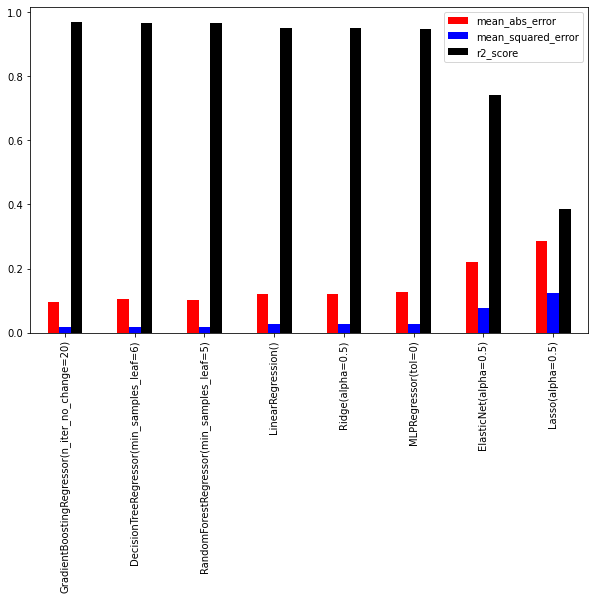

In [79]:
pd.DataFrame(models_perf, index=['mean_abs_error','mean_squared_error','r2_score']).T.sort_values('mean_squared_error').plot(kind = 'bar',figsize=(10,6), color=['Red','Blue','Black'])